In [1]:
import database as db
import datetime as dt
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import label_dict as ld
import warnings
from calendar import monthrange

In [2]:
# Please fill in here the password before usage!!!!
# This line should be executed once in the webpage script in the beginning. 
# Please note that the script needs to run on the server in order to work!
db.set_up_connection(db.db, 'db_weather', user='webscrapers', password='')

In [3]:
def convert_label(label):  
    if label not in ld.ld_dwd:
        warnings.warn('Your label was not valid and will not be plotted! If you are unsure please have a look in label_dict.py or call show_all_labels()')
        return None
    else:
        return ld.ld_dwd[label]

def show_all_labels():
    '''
        Prints all possibles labels that can be queried from the dwd data base.
    '''
    print(list(ld.ld_dwd.keys()))
    
def query_for_plot(time_start, time_end, labels, cities):
    '''
        Parameters:
            time_start = a string giving the beginning of the interval to plot, can be a year (YYYY), 
                         year and month (YYYYMM) or year, month and day (YYYYMMDD) (later on also: or with hour (YYYYMMDDHH))
            time_end = a string giving the end of the interval to 
            labels = The feature you want to plot e.g mean temperature, can be list or scalar. For all possible labels please see label_dict.py or call show_all_labels()
            cities = for which city you want to plot the feature, can be list or scalar
            NOTE: just cities OR labels can be a list, the other one need to be a single value (for now)
        Returns:
            name = title of the plot
            dataframe = pandas dataframe with rows beeing the time (all timestaps can be found in a column called 'dates') 
                        and row corresoning to the freatures asked for (if both, cities and labels are single values, 
                        than the key will be the label, otherwise it will be the items in the list argument)
    '''
    # create dytime interval
    if len(time_start) == 4:
        t_ival = [dt.date(int(time_start),1,1), dt.date(int(time_end),12,31)]
    elif len(time_start) == 6:
        last = monthrange(int(time_end[:4]), int(time_end[4:]))[1]
        t_ival = [dt.date(int(time_start[:4]),int(time_start[4:]),1), dt.date(int(time_end[:4]),int(time_end[4:]),last)]
    elif len(time_start) == 8:
        t_ival = [dt.date(int(time_start[:4]),int(time_start[4:-2]),int(time_start[-2:])), dt.date(int(time_end[:4]),int(time_end[4:-2]),int(time_end[-2:]))]
    elif len(time_start) == 10:
        # see what is the right format for accessing the hourly data as soon as it is in the database
        t_ival = [] #[dt.date(time_start[:4],time_start[4:-2],time_start[-2:]), dt.date(time_end[:4],time_end[4:-2],time_end[-2:])]
    else:
        raise IOError('No valid time format!')
    
    # make sure that the start time is before the end time, if not switch it
    n_days = (t_ival[1]-t_ival[0]).days
    if n_days < 0:
        t_ival = t_ival[::-1]
        n_days = abs(n_days)
    
    # dict which will be converted to the dataframe later on
    data = {}
    
    #if one city and multiple labels are queried
    if np.isscalar(cities) and not np.isscalar(labels):
        # search for the dwd labels in respective dict
        dwd_labels = [ld.ld_dwd[l] for l in labels if l in ld.ld_dwd]
        if len(dwd_labels) != len(labels):
            warnings.warn('Some of your labels were not valid and will not be plotted! If you are unsure please have a look in label_dict.py or call show_all_labels()')
        # make a query to the data base
        query = db.DailyMeasurement.select(lambda m : cities in m.station.stationsname and t_ival[0] <= m.mess_datum and m.mess_datum <= t_ival[1])
        pd_query = db.query_to_dataframe(query)
        # mean over all station with the respective city in the name
        means_db = pd_query.sort_values('mess_datum').groupby('mess_datum').mean()
        # get all queried labels
        for li, label in enumerate(dwd_labels):
            data[label] = list(means_db[label])
        data['dates'] = list(means_db[label].keys())
    # if it is asked for multiple cities and just one label
    elif np.isscalar(labels) and not np.isscalar(cities):
        # search for the dwd labels in respective dict
        dwd_label = convert_label(labels)
        for ci, city in enumerate(cities):
            # make a query to the data base for each city
            query = db.DailyMeasurement.select(lambda m : city in m.station.stationsname and t_ival[0] <= m.mess_datum and m.mess_datum <= t_ival[1])
            pd_query = db.query_to_dataframe(query)
            # mean over all station with the respective city in the name
            means_db = pd_query.sort_values('mess_datum').groupby('mess_datum').mean()
            # get the queried label
            data[city] = list(means_db[dwd_label])
        data['dates'] = list(means_db[dwd_label].keys())
    # if it is asked for just oen city and one label
    else:
        # search for the dwd labels in respective dict
        dwd_label = convert_label(labels)
        # make a query to the data base for each city
        query = db.DailyMeasurement.select(lambda m : cities in m.station.stationsname and t_ival[0] <= m.mess_datum and m.mess_datum <= t_ival[1])
        pd_query =  db.query_to_dataframe(query)
        # mean over all station with the respective city in the name
        means_pd = pd_query.sort_values('mess_datum').groupby('mess_datum').mean()
        data['dates'] = list(means_pd[dwd_label].keys())
        # get the queried label
        data[labels] = list(means_pd[dwd_label])
        
    # create data frame where the date is now a normal column
    data_frame = pd.DataFrame(data=data) 
    return data_frame
    
            

In [4]:
show_all_labels()

['max temperature', 'min temperature', 'mean wind velocity', 'sunshine duration', 'humidity', 'cloud cover', 'max wind gust', 'mean temperature', 'vapor pressure', 'pressure', 'snow depth']


In [5]:
# dirty example
city = 'Berlin'
label = 'max temperature'
lis = []
for i in range(6):
    start = str(2013+i)+'05'
    end = str(2013+i)+'06'
    lis.append(query_for_plot(start, end, label, city))

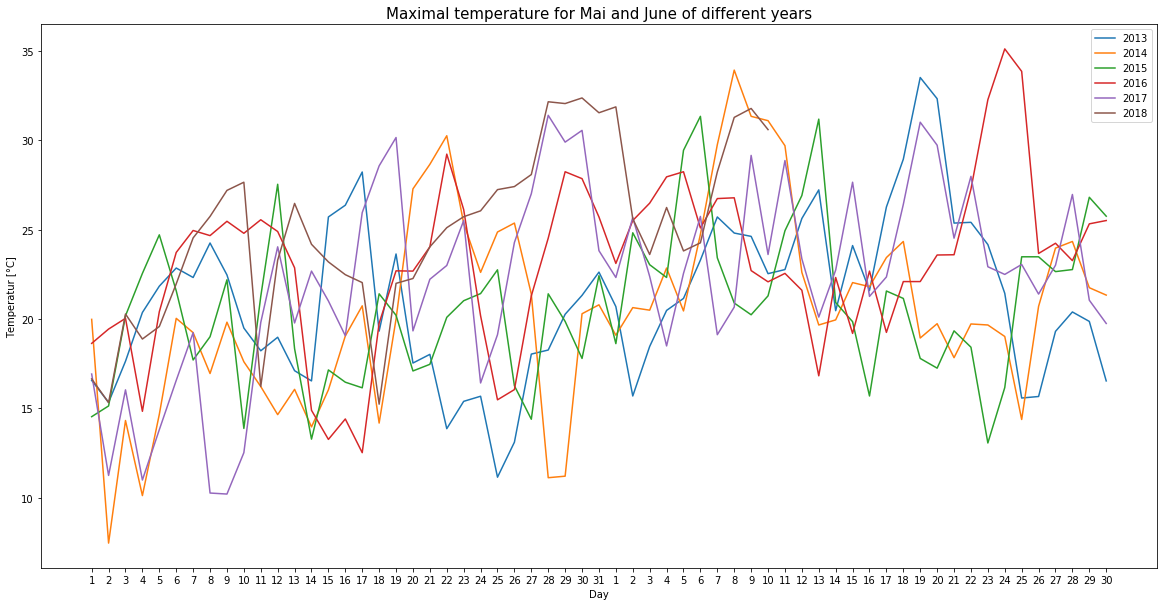

In [6]:
plt.figure(figsize=(20,10))
for i,l in enumerate(lis):
    plt.plot(l[label], label=2013+i)
plt.title('Maximal temperature for Mai and June of different years', fontsize=15)
plt.ylabel('Temperatur [°C]')
plt.xlabel('Day')
days = list(range(1,32))+list(range(1,31))
plt.xticks(range(len(lis[0][label])),days)
plt.legend(loc='best')
plt.show()